We want to analyze participants and patterns of participation across IETF groups. 

Specifically, what are the lengths of participation? Are there new cohorts of participation over time? What is attrition like in IETF mailing list participation? How long do people participate for?

## Setup and gather data

Start by importing the necessary libraries.

In [2]:
%matplotlib inline
import bigbang.mailman as mailman
import bigbang.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
import bigbang.utils as utils
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import pytz
import pickle
import os
import csv
import re
import scipy
import email
import gc

In [3]:
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [4]:
#pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
sns.set()
sns.set_style("white")

In [139]:
def convert_ordinals_to_dates(s): # convenience function for rendering dates in describe tables
    n = []
    if s.name in ['Earliest Date', 'Latest Date']:
        for i, value in s.iteritems():
            if i not in ['std','count']:
                n.append(datetime.date.fromordinal(int(value)).isoformat())
            else:
                n.append(value)
        return pd.Series(data=n, index=s.index, dtype=str)
    return s
def describe_with_dates(df):
    return df.describe().apply(convert_ordinals_to_dates,axis=0)

We'll load data of tenure (earliest date of a message sent, latest date of a message sent, total number of messages sent) that I've already made into a (large) CSV, using the script `tenure.py`. This particular corpus includes all the WG mailing lists for still active WGs that I was able to crawl (**322** successfully collected out of the **364** lists attempted).

In [140]:
tenure_path = '../../ietf-archives/combined-tenure.csv'
tenure_df = pd.read_csv(tenure_path)
describe_with_dates(tenure_df)

,Earliest Date,Total Messages,Latest Date
count,120527,120555.000000,120527
mean,2006-06-11,11.138559,2006-11-21
std,7905.45,121.384299,6829.6
min,0100-01-10,0.000000,0100-01-12
25%,2004-09-30,1.000000,2005-01-18
50%,2007-03-17,1.000000,2007-04-26
75%,2007-12-27,2.000000,2008-01-16
max,2017-10-20,20279.000000,2017-10-23


In [6]:
tenure_df['Total Messages'].sum()

1342809.0

That's over **120,000** senders (although some of those are duplicates we would like to combine) that have sent over **1.3 million** messages.

We have some outliers / bad data that crept in. Let's see how much and ignore them for now.

In [7]:
tenure_df[tenure_df['Earliest Date'] < 726468].count()

From              45
Earliest Date     45
Total Messages    45
Latest Date       45
dtype: int64

We'll just use data from the 1990s and later, as I suspect earlier records were using incorrect dates (like a handful at the Unix epoch of January 1, 1970). It's not very many people (27 out of 120,000) although a couple are significant senders, so sometime it would be good to just drop individual messages with bad dates, rather than the person's whole tenure.

In [142]:
tenure_df = tenure_df[tenure_df['Earliest Date'] > 726468]

## When do people first send to a mailing list?

We'll create a histogram of people and when they sent their first message to any list.

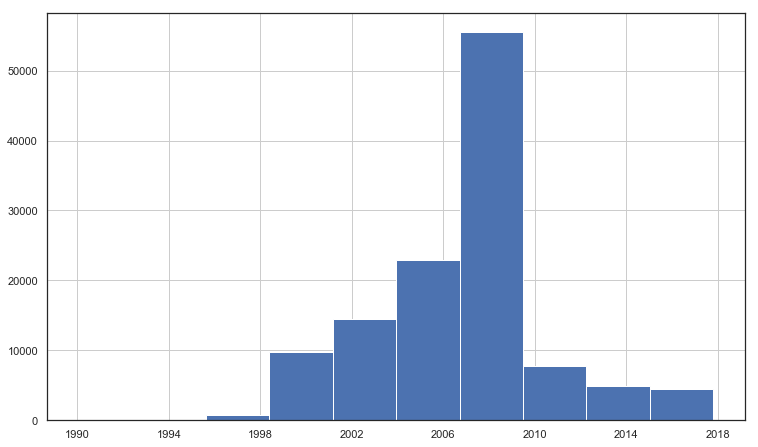

In [9]:
fig = plt.figure(figsize=(12.5, 7.5))

tenure_df['Earliest Date'].hist()

fig.axes[0].xaxis_date()

We have a peak in late-2000s on new participation, with a sudden drop-off. (Caution, that is likely just be where the peak of this corpus of messages is present, including one-off spam messages, especially since the histogram also peaks there for last message sent.)

## For how long do participants remain?

We can calculate a "tenure" concept, which is the number of days between your first message to an IETF list and your latest message.

In [143]:
tenure_df['Tenure'] = tenure_df['Latest Date'] - tenure_df['Earliest Date']

In [144]:
describe_with_dates(tenure_df)

,Earliest Date,Total Messages,Latest Date,Tenure
count,120482,120482.000000,120482,120482.000000
mean,2006-09-11,11.125031,2007-01-27,138.560258
std,1356.57,121.356436,1439.61,504.066730
min,1990-01-29,1.000000,1990-01-29,0.000000
25%,2004-10-01,1.000000,2005-01-19,0.000000
50%,2007-03-17,1.000000,2007-04-27,0.000000
75%,2007-12-27,2.000000,2008-01-16,1.000000
max,2017-10-20,20279.000000,2017-10-23,7408.000000


Let's graph data for people for whom we have at least a few messages.

In [12]:
working_data = tenure_df[tenure_df['Total Messages'] > 3]

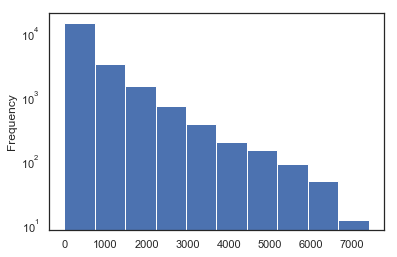

In [13]:
working_data['Tenure'].plot(kind ='hist',logy=True)

The distribution of tenure seems to be a power law, although not exactly. (The above graph is log scale in the y dimension.) Most people have short tenures, with fewer and fewer people as the tenure extends.

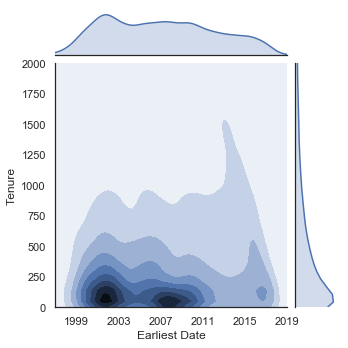

In [14]:
fig = sns.jointplot(kind='kde', 
                    data = working_data, 
                    x='Earliest Date', 
                    y='Tenure', 
                    xlim=(datetime.date(1997,1,1).toordinal(),datetime.date(2019,1,1).toordinal()), 
                    ylim=(0, 2000),
                    height=5)
fig.ax_joint.xaxis_date()
fig.savefig('graphs/tenure-density-plot.png',dpi=300)

This plot shows the density of people around when they first sent a message and how long their tenure has been. Maybe this can help us answer the question: are the earlier participants more likely to be long-lasting? This suggests that that isn't the case, that there is even a slight tendency for the long-tenure participants to be more recent joiners. (Caveat, that might also be an artifact of the corpus being WGs that are still active.)

For the subset of senders who have more than 3 total messages, let's see when they first and last sent messages.

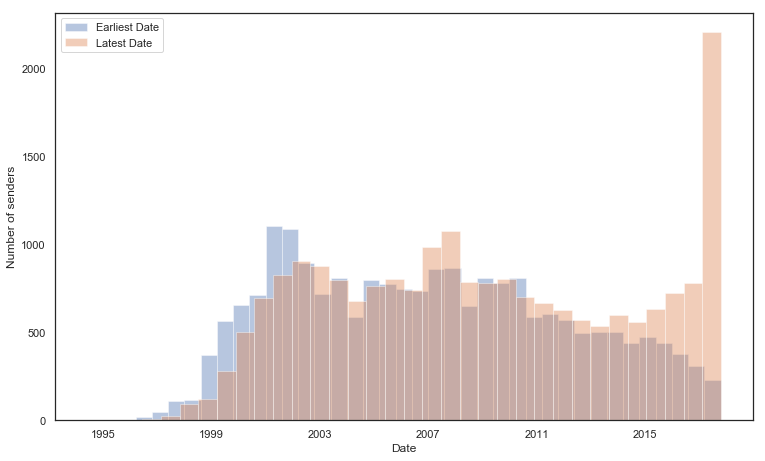

In [145]:
fig = plt.figure(figsize=(12.5, 7.5))

ax = sns.distplot(working_data['Earliest Date'], label='Earliest Date', norm_hist=False, kde=False)
sns.distplot(working_data['Latest Date'], label='Latest Date', ax=ax, norm_hist=False, kde=False)
ax.legend()
ax.xaxis_date()
ax.set_xlabel('Date')
ax.set_ylabel('Number of senders')
fig.savefig('graphs/earliest-latest-histograms.png',dpi=300)

Latest Date has a histogram peak in the most recent year because for everyone who's still sending messages, their last message can't be later than this year, and that might also explain some of the increase up to that peak. But the decrease in Earliest Date frequency in more recent years is a little more surprising. Is IETF getting fewer newcomer participants in the past few years?

There are a couple of alternative explanations that we might explore before drawing a strong conclusion from that. Is message traffic overall decreasing (or increasing) during that same period of new mailing list participant decline? If it is, that might be evidence of a shift away from mailing list traffic, rather than a shift away from new participants, and maybe Github issue threads increased as a substitute. Also, since we limited our corpus to people who sent at least a few messages, it could be that some participants send multiple messages but quite spread out, over a few years even, and so if those people started earlier, they're in the corpus, but if they haven't reached the cutoff yet (at least 4 messages) but would in the future, they're excluded.

---

From the above, we know a little of how many people first and last sent messages for any given timeframe, but that doesn't give us a view of the cohorts, of who is participating at a given time and when they started. I'd like to show overlapping line segments in order to give an impression of the overlapping tenures of participation. Let's try?

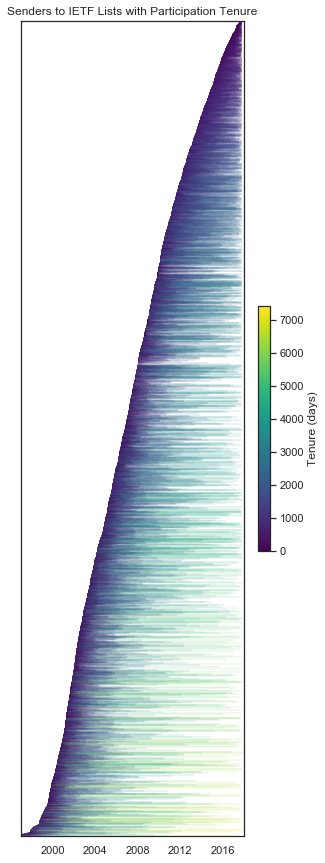

In [16]:
sorted_df = working_data.sort_values(by=['Earliest Date'])

ys= np.arange(sorted_df['From'].count())
segments = []
for y in ys:
    start = [sorted_df['Earliest Date'].iloc[y], y]
    end = [sorted_df['Latest Date'].iloc[y], y]
    segments.append([start,end])
line_segments = matplotlib.collections.LineCollection(segments, 
                                                      linewidths=[0.2], 
                                                      cmap='viridis', 
                                                      norm=matplotlib.colors.Normalize(vmin=0,vmax=7408))
line_segments.set_array(sorted_df['Tenure'])

fig = plt.figure(figsize=(5, 15))
ax = plt.axes()
ax.set_xlim(datetime.date(1997,1,1).toordinal(),datetime.date(2018,1,1).toordinal())
ax.set_ylim(ys.min(), ys.max())
ax.xaxis_date()
ax.yaxis.set_visible(False)
ax.add_collection(line_segments)
cb = fig.colorbar(line_segments, shrink=0.3)
cb.set_label('Tenure (days)')
ax.set_title('Senders to IETF Lists with Participation Tenure')
fig.savefig('graphs/tenure-lines.png',dpi=300)

This graph is colorful, and I'd like to think it's aesthetically pleasing, but what can we learn from it? It seems that no dramatic trend stands out. That is, there is a mix of short-lived and long-lived participants at each starting time. Except for a couple of small gaps, participants who joined more recently are more likely to still be participating, but of course those participants can't have as long a potential tenure.

Perhaps another way to show that data more quantitatively is to graph the cumulative percentage of people who first started sending messages in a particular year who have participated for longer than X days. That would let us compare directly for any given timeframe (say, 2+ years) whether any particular starting point is more likely to have that timeframe. This might be similar to the density plot, but with aggregation and percentages, rather than comparing colors for density.

In [17]:
#TODO

## How many messages do people send?

This dataset also includes the total number of messages that each person has sent. Do earlier participants, or longer-lasting participants, always send more messages? Or might people who only participate in one working group for a year or two often send many messages during that time?

First, let's get an overview of the data on the total messages sent by each person. (As above, our working data set is limited to people who have sent more than 3 messages.)

In [19]:
working_data['Total Messages'].describe()

count    21157.000000
mean        57.610389
std        285.040649
min          4.000000
25%          5.000000
50%         10.000000
75%         30.000000
max      20279.000000
Name: Total Messages, dtype: float64

[None]

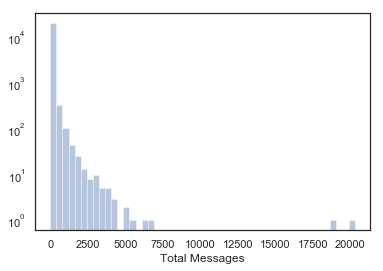

In [74]:
fig = sns.distplot(working_data['Total Messages'], hist=True, kde=False)
fig.set(yscale="log")

With some outliers (a handful of senders have sent several thousand messages, including one that sent over 20,000 messages), the distribution is intensely skewed-right and unimodal.

In [148]:
working_data[working_data['Total Messages'] > 5000].sort_values(by='Total Messages', ascending=False) \
                                                   .apply(convert_ordinals_to_dates,axis=0)

,From,Earliest Date,Total Messages,Latest Date,Tenure
90051,Internet-Drafts@ietf.org,1996-11-19,20279.0,2017-03-02,7408.0
114293,internet-drafts@ietf.org,2005-06-07,18918.0,2017-10-23,4521.0
107248,The IESG <iesg-secretary@ietf.org>,1997-11-12,6693.0,2017-10-20,7282.0
82307,Brian E Carpenter <brian.e.carpenter@gmail.com>,2007-05-22,6234.0,2017-10-23,3807.0
92582,Juergen Schoenwaelder <j.schoenwaelder@jacobs-...,2007-05-10,5329.0,2017-10-23,3819.0
83452,Christer Holmberg <christer.holmberg@ericsson....,2009-12-14,5244.0,2017-10-20,2867.0


Outliers include a few individuals who have sent a lot of messages from the same email address over several years, and a couple of organizational, automated accounts. `internet-drafts@ietf.org` sends automated emails whenever a new draft of a new document is published, which happens a lot!

I would expect that people who have participated over a longer period of time send more messages, but I don't know how strongly that will hold.

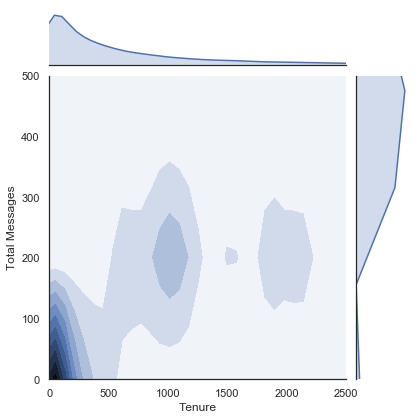

In [78]:
sns.jointplot(
    x="Tenure", 
    y="Total Messages", 
    ylim=(0, 500), 
    xlim=(0, 2500),
    data=working_data, 
    kind="kde");

TODO: it might be better to limit the data to the vast majority of the participants first, and then to graph it, rather than calculating the density across the entire spread and then cutting short the graph.

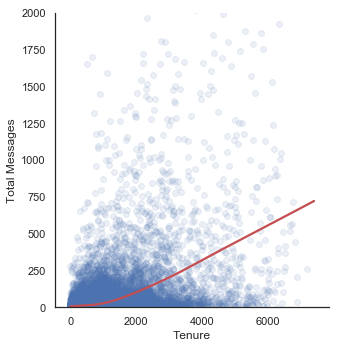

In [100]:
g = sns.lmplot(
    x="Tenure", 
    y="Total Messages", 
    data=working_data,
    lowess=True,
    scatter_kws={'alpha':0.1},
    line_kws={'color':'r'});
g.set(ylim=(0,2000)) # hard to see the trend when you include the prominent outliers

While there is a trend towards more messages the longer a time that you've participated, the lowess-smoothed line suggests that that trend is much stronger once participants have been participating for years, and that among shorter-term participants, the distribution is more normal.

Do people who started participating earlier send more messages? While that would seem possible (because you could have a longer tenure and had more time to send more messages), it shouldn't be very strong unless there's been a substantial change in the kind of participations who have joined.

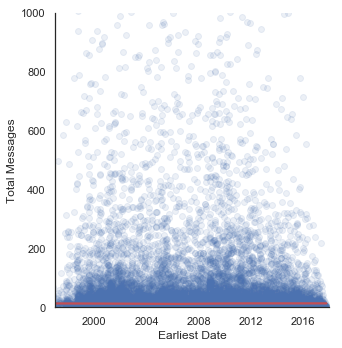

In [103]:
g = sns.lmplot(
    x="Earliest Date", 
    y="Total Messages", 
    data=working_data,
    lowess=True,
    scatter_kws={'alpha':0.1},
    line_kws={'color':'r'});
g.set(ylim=(0,1000)) # hard to see the trend when you include the prominent outliers
g.ax.set_xlim(datetime.date(1997,1,1).toordinal(),datetime.date(2018,1,1).toordinal())
g.ax.xaxis_date()

A flat trend line, as expected. We can ignore further inquiry along those lines, I think.